In [2]:
import sys
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

sys.path.insert(1, '../rule_lib')
sys.path.insert(1, '../../../notes/1-Testing/fuzzy-test/python/')

from rule_extraction import *

%load_ext autoreload
%autoreload 2
%matplotlib widget

# Load Data from Folders


In [3]:
dataPairs = []

directories = []
for root, dirs, files in os.walk("../../tuning-results-pause-during-examples/data-wsl2/"):
    for name in dirs:
        directories.append(os.path.join(root, name))


for directory in directories:

    files = os.listdir(directory)
    for file in files:
        if "liveInfoLogger" in file:
            liveInfo = pd.read_csv(directory + "/" + file)
            liveInfo = liveInfo.dropna()
        if "tuningData" in file:
            tuningData = pd.read_csv(directory + "/" + file)
            tuningData = tuningData.dropna()
        if "tuningResults" in file:
            tuningResults = pd.read_csv(directory + "/" + file)
            tuningResults = tuningResults.dropna()

    # filter rows where NaN is present

    tuning_iterations = tuningData["Iteration"]

    corresponding_liveInfo = liveInfo.loc[liveInfo["Iteration"].isin(
        tuning_iterations)]

    assert len(corresponding_liveInfo) == len(
        tuningData), "Length of liveInfo and tuningData does not match"

    # strip columns
    corresponding_liveInfo.columns = corresponding_liveInfo.columns.str.strip()
    tuningData.columns = tuningData.columns.str.strip()

    # convert tuningData timings into percentages
    maxTime = tuningData["Reduced"].max()
    tuningData.insert(1, "PerformancePercentage", (
        tuningData["Reduced"] / maxTime) * 100)

    # merge container and Data Layout
    tuningData["Container_DataLayout"] = tuningData["Container"] + \
        "_" + tuningData["Data Layout"]

    tuningData.drop(columns=["Container", "Data Layout"], inplace=True)

    dataPairs.append((corresponding_liveInfo, tuningData))

In [4]:
df = pd.DataFrame()

for batch, (X, y) in enumerate(dataPairs):
    merged = pd.merge(X, y, on="Iteration")
    df = pd.concat([df, merged])

df = df.drop(columns=["Iteration", "Date_x", "Date_y"])
df = df.drop(list(df.filter(regex='sample')), axis=1)
df.shape

(28995, 29)

In [5]:
df.describe()

avgParticlesPerCell        cutoff   domainSizeX   domainSizeY  \
count         28995.000000  28995.000000  28995.000000  28995.000000   
mean              1.054852      2.915796     61.454026     62.160700   
std               1.590543      0.231970     24.336494     23.533981   
min               0.068390      2.000000     15.000000     29.561231   
25%               0.305312      3.000000     50.000000     50.000000   
50%               0.547120      3.000000     50.000000     50.000000   
75%               0.944637      3.000000    100.000000    100.000000   
max               7.061688      3.000000    100.000000    100.000000   

        domainSizeZ  estimatedNumNeighborInteractions   homogeneity  \
count  28995.000000                      2.899500e+04  28995.000000   
mean      60.516804                      1.307551e+05      0.085897   
std       25.100458                      1.921074e+05      0.103670   
min       15.000000                      3.285000e+03      0.003197   
25%       50.000000                      3.356400e+04      0.027972   
50%       50.000000                      8.085200e+04      0.044302   
75%      100.000000                      9.396900e+04      0.082399   
max      100.000000                      1.032785e+06      0.547827   

         maxDensity  maxParticlesPerCell  minParticlesPerCell  ...  \
count  28995.000000         28995.000000              28995.0  ...   
mean       0.525502            20.194447                  0.0  ...   
std        0.331931             7.418830                  0.0  ...   
min        0.016158             3.000000                  0.0  ...   
25%        0.212400            16.000000                  0.0  ...   
50%        0.520800            22.000000                  0.0  ...   
75%        0.688200            24.000000                  0.0  ...   
max        1.879647            51.000000                  0.0  ...   

       particleSizeNeededByFunctor  particlesPerBlurredCellStdDev  \
count                      28995.0                   28995.000000   
mean                          72.0                       0.328594   
std                            0.0                       0.255194   
min                           72.0                       0.024498   
25%                           72.0                       0.215287   
50%                           72.0                       0.299439   
75%                           72.0                       0.349292   
max                           72.0                       2.008868   

       particlesPerCellStdDev  rebuildFrequency          skin  threadCount  \
count            28995.000000      28995.000000  28995.000000      28995.0   
mean                 0.045470         10.281945      1.064287         12.0   
std                  0.060040          1.153377      0.504678          0.0   
min                  0.011771         10.000000      0.200000         12.0   
25%                  0.017843         10.000000      1.000000         12.0   
50%                  0.040432         10.000000      1.000000         12.0   
75%                  0.045114         10.000000      1.000000         12.0   
max                  0.478737         15.000000      3.000000         12.0   

       PerformancePercentage  CellSizeFactor       Reduced      Smoothed  
count           28995.000000         28995.0  2.899500e+04  2.899500e+04  
mean               17.614313             1.0  5.152688e+07  4.810560e+07  
std                12.772694             0.0  1.008837e+08  8.905544e+07  
min                 1.244363             1.0  6.842310e+05  6.842310e+05  
25%                 9.047065             1.0  1.546685e+07  1.485115e+07  
50%                13.986347             1.0  2.562822e+07  2.468236e+07  
75%                22.417374             1.0  4.520086e+07  4.347496e+07  
max               100.000000             1.0  2.168150e+09  1.934718e+09  

[8 rows x 25 columns]

In [6]:
df.columns

Index(['avgParticlesPerCell', 'cutoff', 'domainSizeX', 'domainSizeY',
       'domainSizeZ', 'estimatedNumNeighborInteractions', 'homogeneity',
       'maxDensity', 'maxParticlesPerCell', 'minParticlesPerCell', 'numCells',
       'numEmptyCells', 'numHaloParticles', 'numParticles', 'particleSize',
       'particleSizeNeededByFunctor', 'particlesPerBlurredCellStdDev',
       'particlesPerCellStdDev', 'rebuildFrequency', 'skin', 'threadCount',
       'PerformancePercentage', 'CellSizeFactor', 'Traversal',
       'Load Estimator', 'Newton 3', 'Reduced', 'Smoothed',
       'Container_DataLayout'],
      dtype='object')

# Define Interesting Data to observe


In [7]:
inputs = [
    "avgParticlesPerCell",
    # "cutoff",
    # "domainSizeX",
    # "domainSizeY",
    # "domainSizeZ",
    # "estimatedNumNeighborInteractions",
    'homogeneity',
    'maxDensity',
    "maxParticlesPerCell",
    # "minParticlesPerCell",
    # "numCells",
    # "numEmptyCells",
    # "numHaloParticles",
    # "numParticles",
    # "particleSize",
    # "particleSizeNeededByFunctor",
    # "particlesPerBlurredCellStdDev",
    "particlesPerCellStdDev",
    # "rebuildFrequency",
    # "skin",
    # "threadCount",
]

outputs = [
    "Container_DataLayout",
    # "CellSizeFactor",
    "Traversal",
    # "Load Estimator",
    "Newton 3",
]

In [8]:
df.columns

Index(['avgParticlesPerCell', 'cutoff', 'domainSizeX', 'domainSizeY',
       'domainSizeZ', 'estimatedNumNeighborInteractions', 'homogeneity',
       'maxDensity', 'maxParticlesPerCell', 'minParticlesPerCell', 'numCells',
       'numEmptyCells', 'numHaloParticles', 'numParticles', 'particleSize',
       'particleSizeNeededByFunctor', 'particlesPerBlurredCellStdDev',
       'particlesPerCellStdDev', 'rebuildFrequency', 'skin', 'threadCount',
       'PerformancePercentage', 'CellSizeFactor', 'Traversal',
       'Load Estimator', 'Newton 3', 'Reduced', 'Smoothed',
       'Container_DataLayout'],
      dtype='object')

# Filter Data / Outliers


In [9]:
# only keep rows where performance percentage is above x
dffiltered = df[df["PerformancePercentage"] >= 70]


def combine_columns(row):
    return ", ".join(sorted(map(str, list(np.unique(row)))))


# group data on input columns and concatenate output columns
dfgrouped = dffiltered.groupby(inputs).agg(combine_columns).reset_index()

# remove columns that are not needed
dfgrouped.drop(columns=["Reduced", "Smoothed",
               "PerformancePercentage"], inplace=True)

X, y = dfgrouped[inputs], dfgrouped[outputs]

print(X.shape, y.shape)

(100, 5) (100, 3)


# Create Train and Test Data


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# save to csv
pd.concat([X_train, y_train], axis=1).to_pickle("train.pkl")
pd.concat([X_test, y_test], axis=1).to_pickle("test.pkl")

# Final Data


In [11]:
pd.concat([X_train, y_train], axis=1).head()

avgParticlesPerCell  homogeneity  maxDensity  maxParticlesPerCell  \
55             0.944637     0.082461    0.684480                 23.0   
88             2.305438     0.086579    0.573123                 11.0   
26             0.944637     0.081545    0.688200                 23.0   
42             0.944637     0.082044    0.706800                 24.0   
69             0.944637     0.082888    0.662160                 21.0   

    particlesPerCellStdDev                             Container_DataLayout  \
55                0.040583          LinkedCells_AoS, VerletClusterLists_AoS   
88                0.013639  PairwiseVerletLists_SoA, VerletClusterLists_AoS   
26                0.039974          LinkedCells_AoS, VerletClusterLists_AoS   
42                0.040130          LinkedCells_AoS, VerletClusterLists_AoS   
69                0.040563          LinkedCells_AoS, VerletClusterLists_AoS   

                                            Traversal  Newton 3  
55                                    lc_c04, vcl_c06  disabled  
88  vcl_sliced, vcl_sliced_c02, vlp_c08, vlp_c18, ...  disabled  
26                                    lc_c04, vcl_c06  disabled  
42                                    lc_c04, vcl_c06  disabled  
69                                    lc_c04, vcl_c06  disabled

In [12]:
for i, col in enumerate(y.columns):

    y_count = y[col].value_counts()

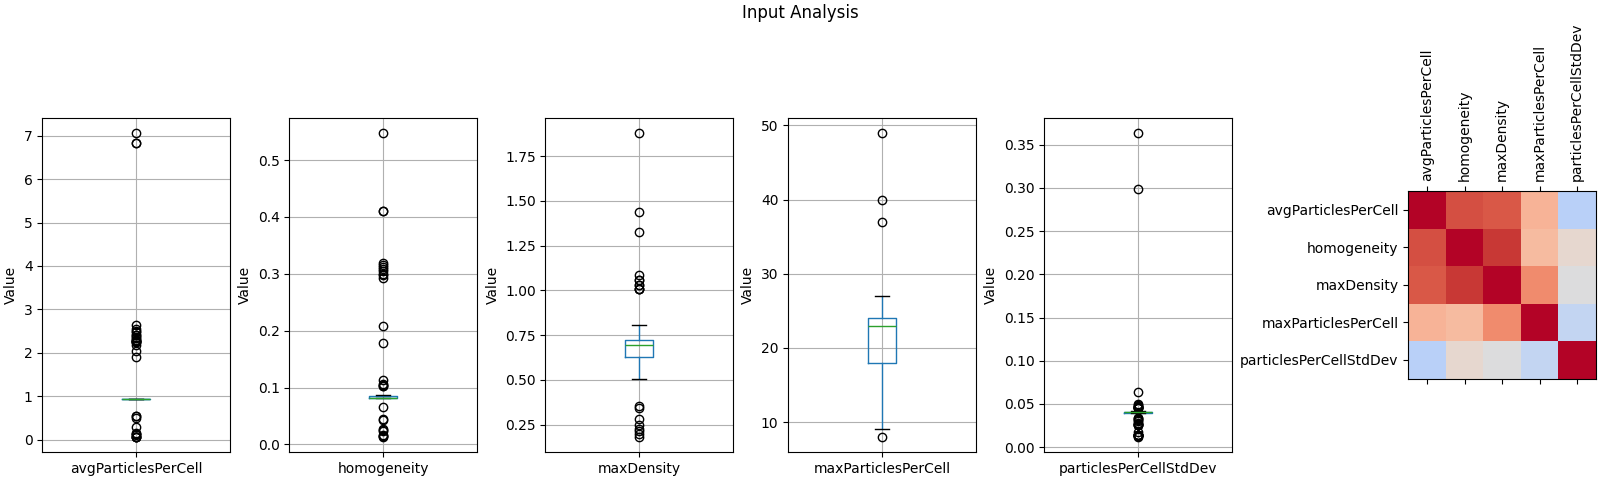

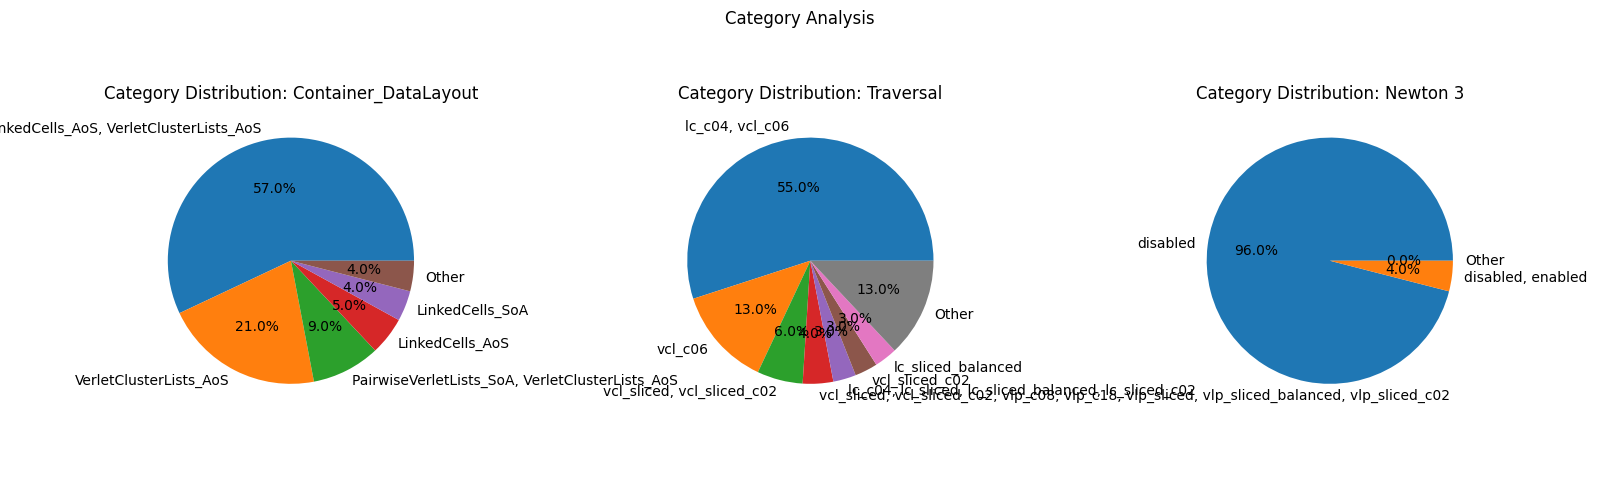

In [13]:
import seaborn as sns

# Row 1
fig, ax1 = plt.subplots(1, len(X.columns)+1, constrained_layout=True)

fig.suptitle("Input Analysis")
fig.set_figwidth(16)

for i, col in enumerate(X.columns):
    X[[col]].boxplot(ax=ax1[i], showfliers=True)
    ax1[i].set_ylabel("Value")

i += 1
# Correlation Matrix
corr = X.corr()
cax = ax1[i].matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
ax1[i].set_xticks(range(len(X.columns)))
ax1[i].set_yticks(range(len(X.columns)))
ax1[i].set_xticklabels(X.columns, rotation=90)
ax1[i].set_yticklabels(X.columns)


# Row 2
fig, ax1 = plt.subplots(1, len(y_train.columns))
fig.suptitle("Category Analysis")
fig.set_figwidth(16)
fig.tight_layout(pad=3.0)


for i, col in enumerate(y.columns):
    y_count = y[col].value_counts()

    total = y_count.sum()

    # grouping categories with less than 2% of the total
    y_count_group = y_count[y_count.gt(total*0.02)]
    y_count_group["Other"] = y_count[~y_count.index.isin(
        y_count_group.index)].sum()

    ax1[i].pie(y_count_group, labels=y_count_group.index, autopct='%1.1f%%')
    ax1[i].set_title(f"Category Distribution: {col}")

# Train Decision Tree and Extract Rules


In [29]:
# number of input parameters that can be used simultaneously
POSSIBLE_NUMBER_OF_COMBINATIONS = [2, 3, 4, 5]

CCP_ALPHA = {
    "Container_DataLayout": 0.1,
    "Traversal": 0.1,
    "Newton 3": 0.01,

}

# maximum depth of the decision tree
MAX_DEPTH = 5

# how many trees should be used to create rules for each label
TOP_K_MODELS_PER_LABEL = 2

Training on 80 samples
Number of rules 33:
	Container_DataLayout (10 rules)
	Traversal (9 rules)
	Newton 3 (14 rules)


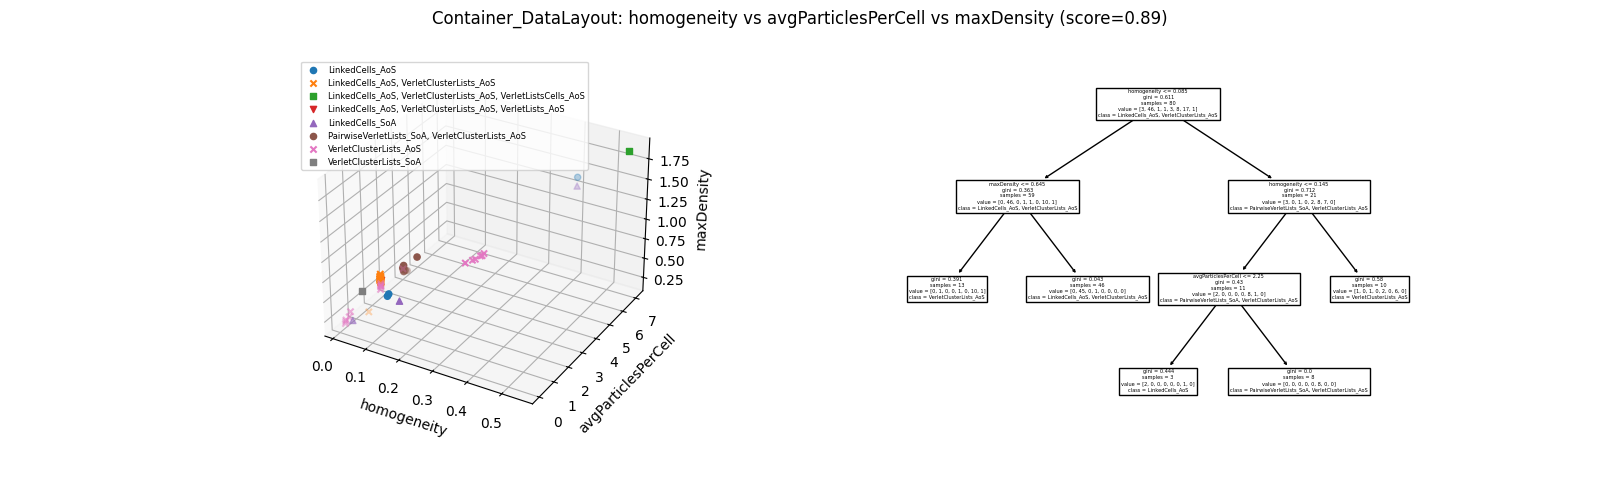

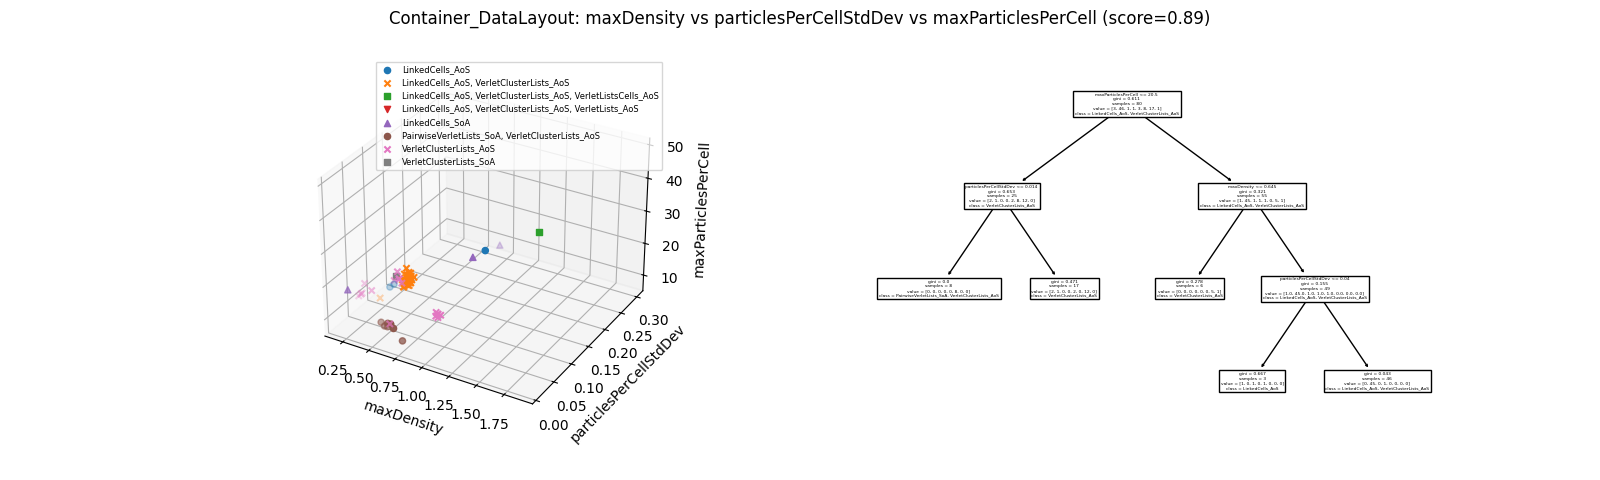

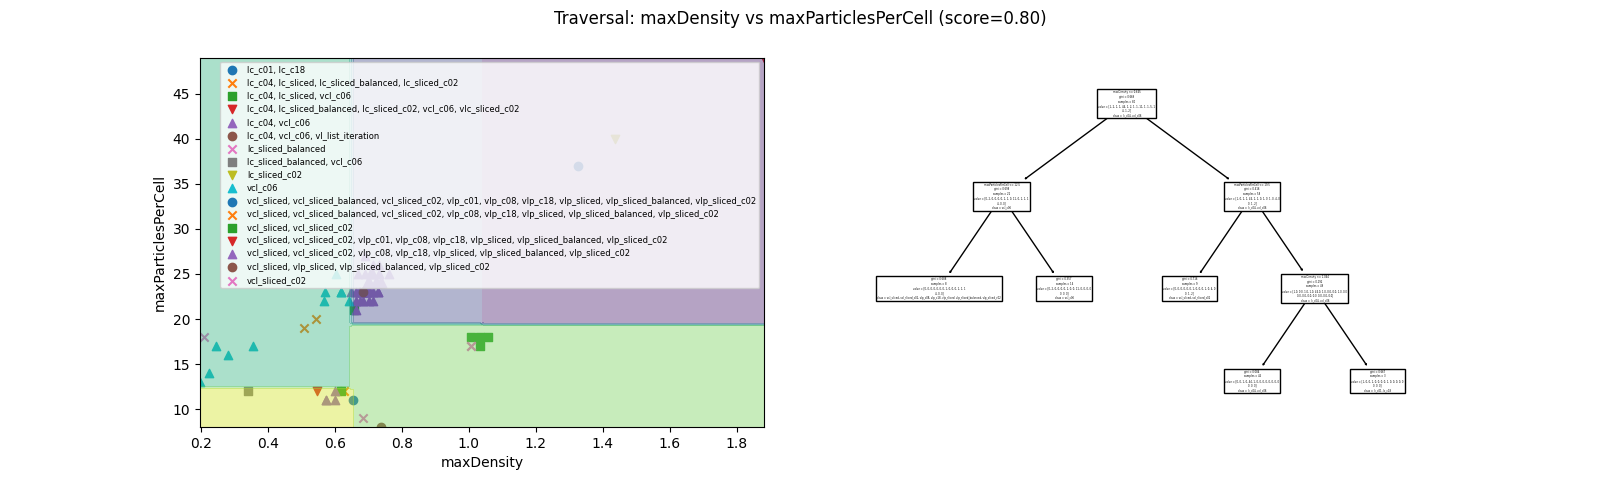

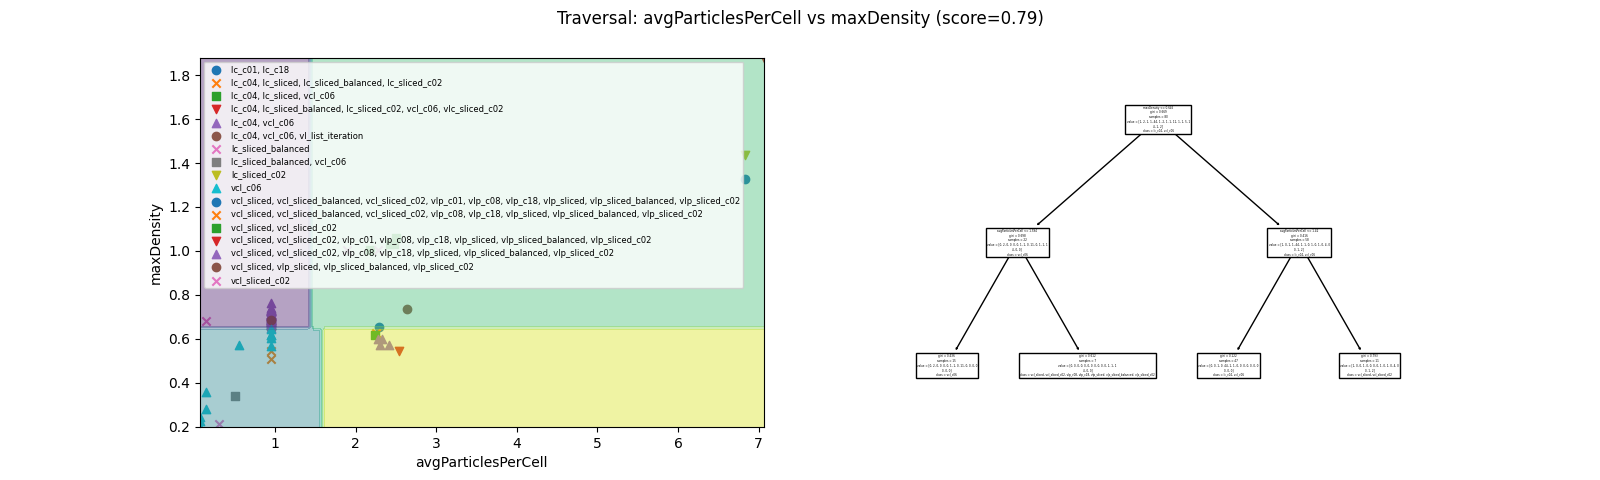

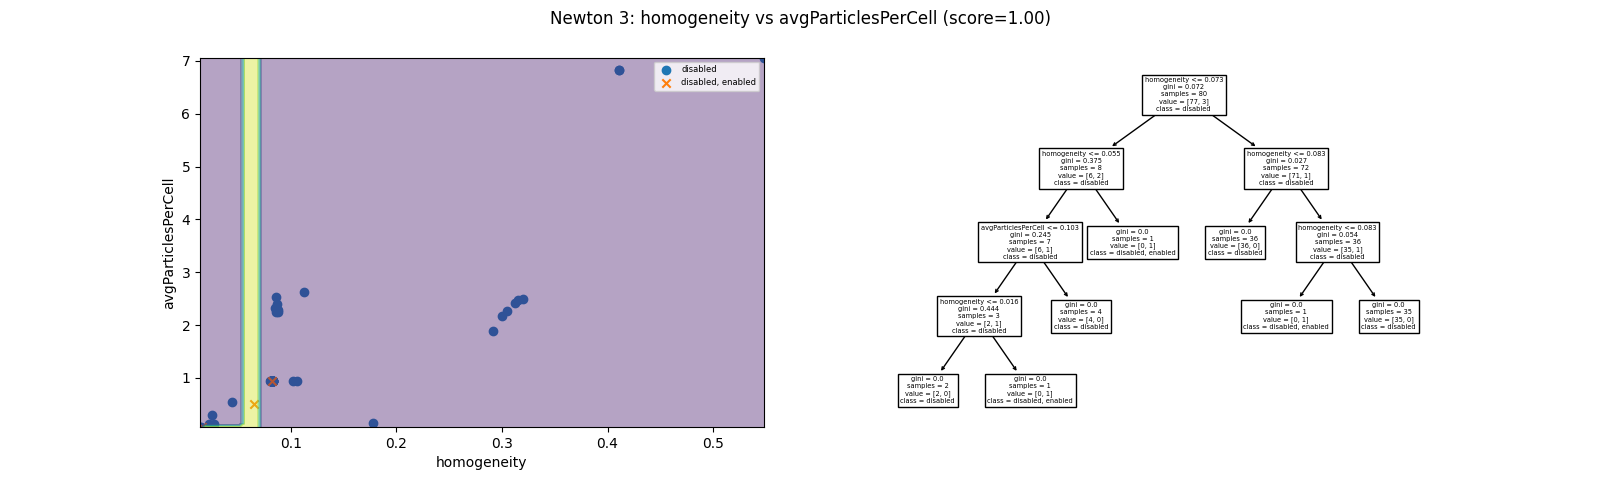

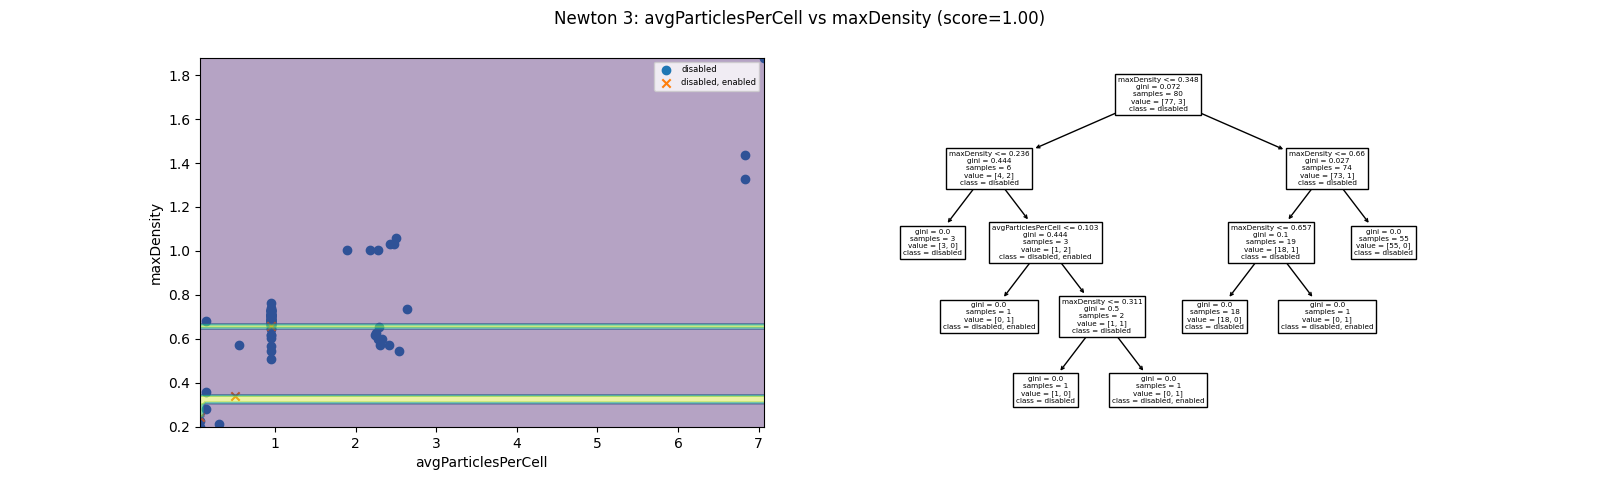

In [30]:
auto_rules = create_auto_rules(X_train, y_train,  None,
                               POSSIBLE_NUMBER_OF_COMBINATIONS, CCP_ALPHA, MAX_DEPTH, TOP_K_MODELS_PER_LABEL)

maxDensity: [-inf, 0.425, 0.556, 0.645, 0.871, 1.044, inf]
maxDensity: [-inf, 0.425, 0.556, 0.645, 0.871, 1.044, inf]

avgParticlesPerCell: [-inf, 0.221, 0.546, 0.746, 1.42, 2.25, 4.663, inf]
avgParticlesPerCell: [-inf, 0.221, 0.546, 0.746, 1.42, 2.25, 4.663, inf]

maxParticlesPerCell: [-inf, 12.5, 19.5, inf]
maxParticlesPerCell: [-inf, 12.5, 19.5, inf]

particlesPerCellStdDev: [-inf, 0.05, 0.181, inf]
particlesPerCellStdDev: [-inf, 0.05, 0.181, inf]



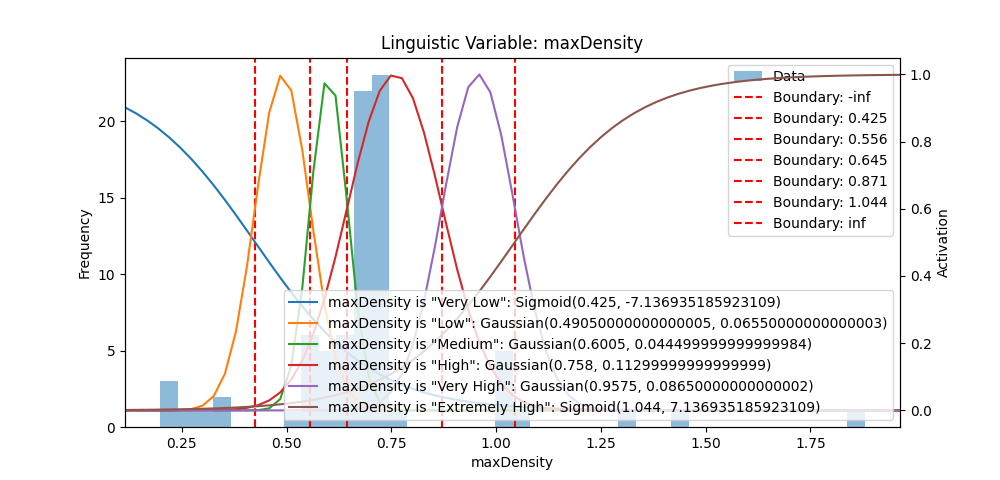

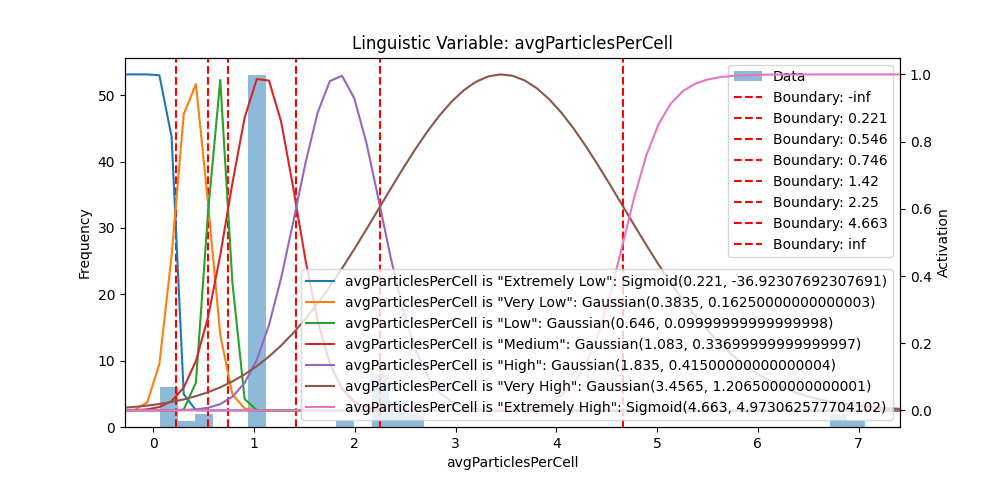

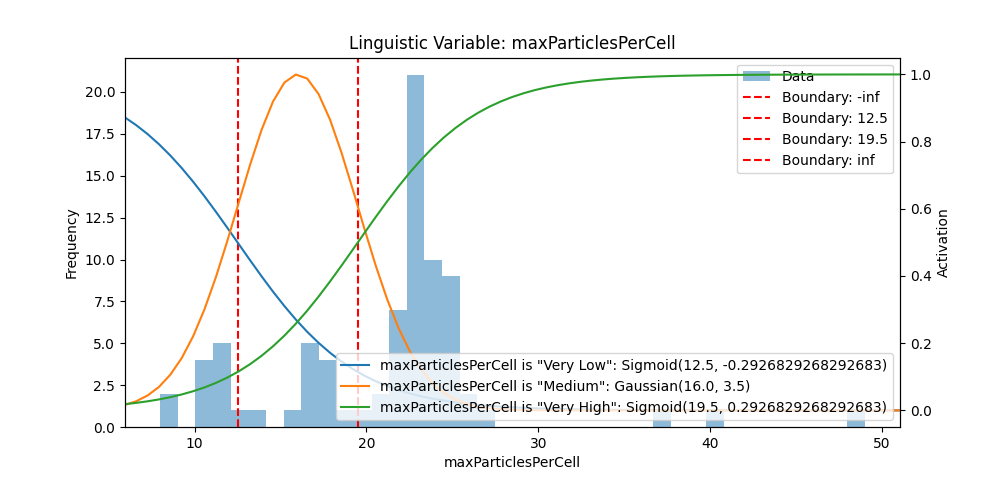

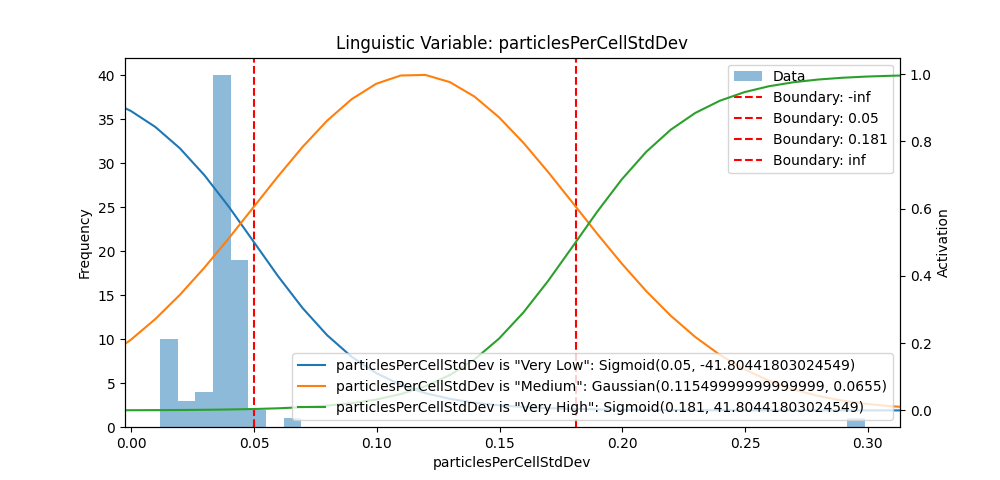

In [16]:
inputs_approach1, rules_approach1 = create_rules_approach1(
    X_train, auto_rules)

# Aproach 2

Follows https://www.sciencedirect.com/science/article/pii/S0165011406002533


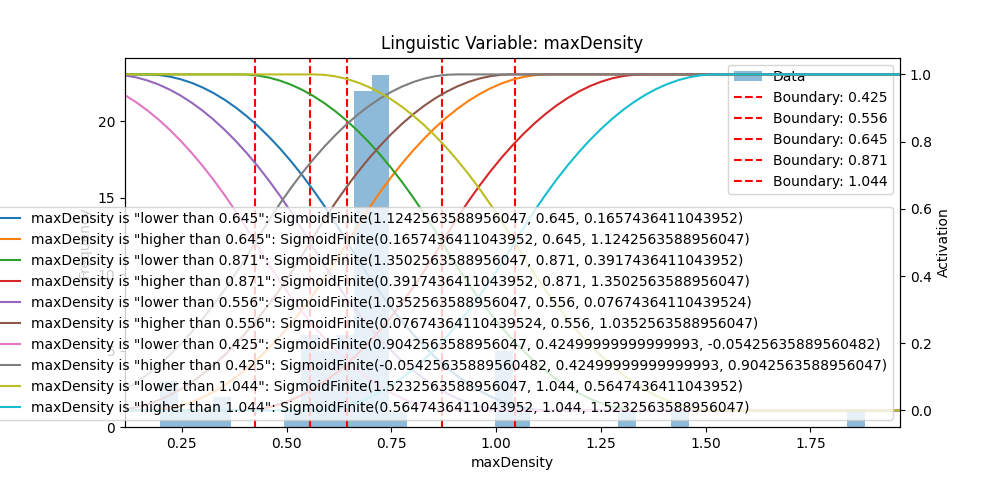

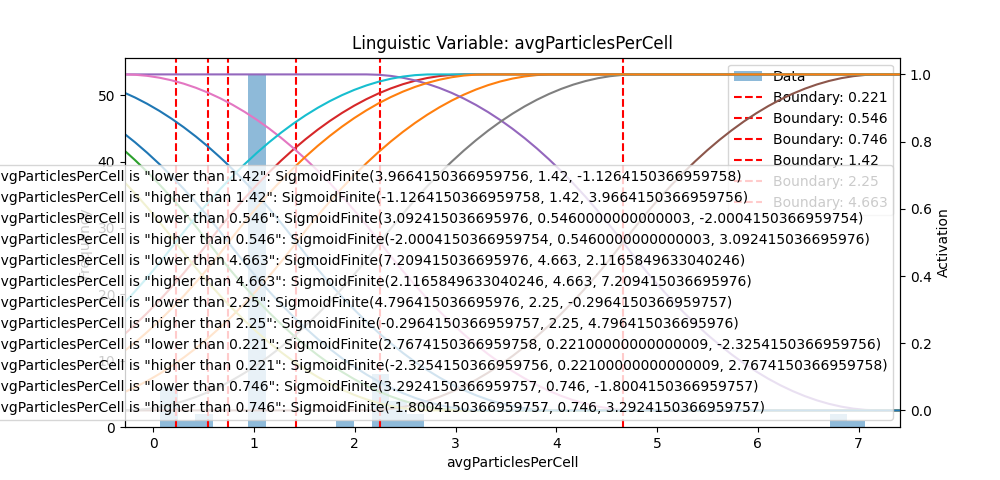

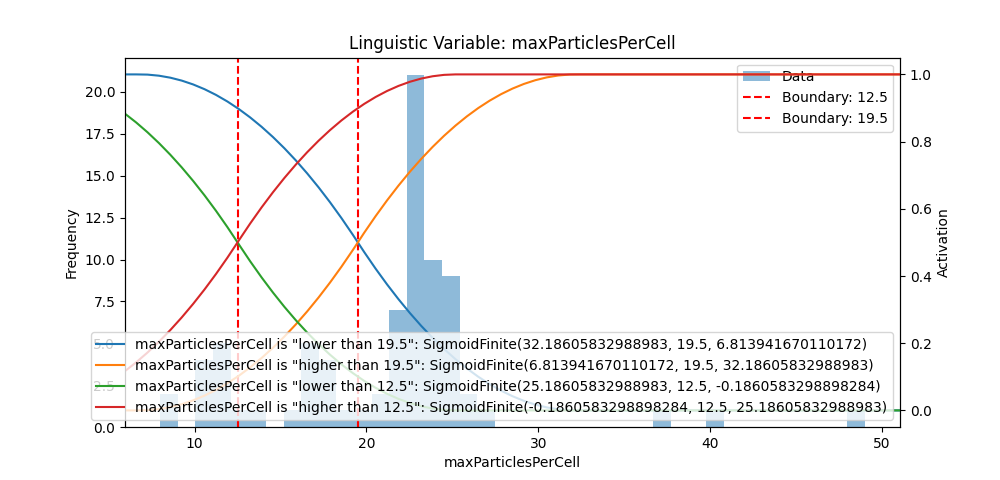

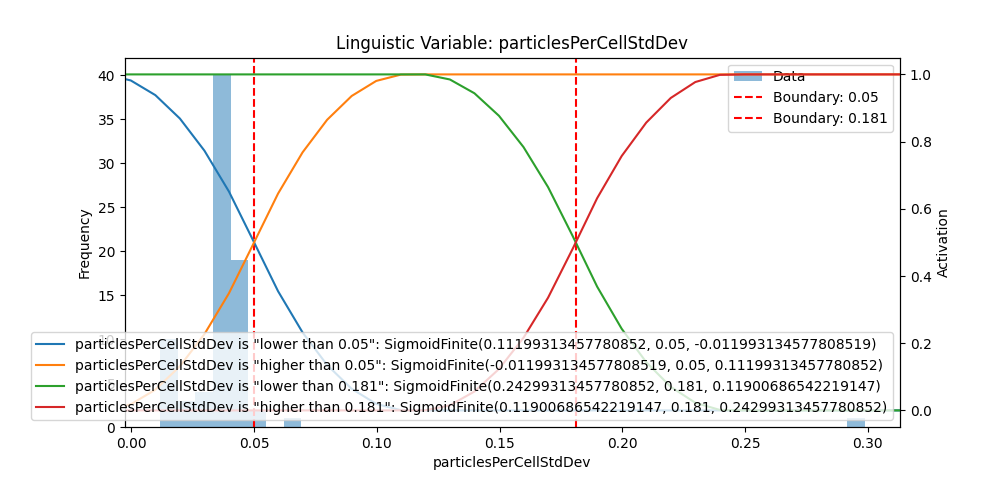

In [17]:
inputs_approach_2, rules_approach2 = create_rules_approach2(
    X_train, auto_rules)

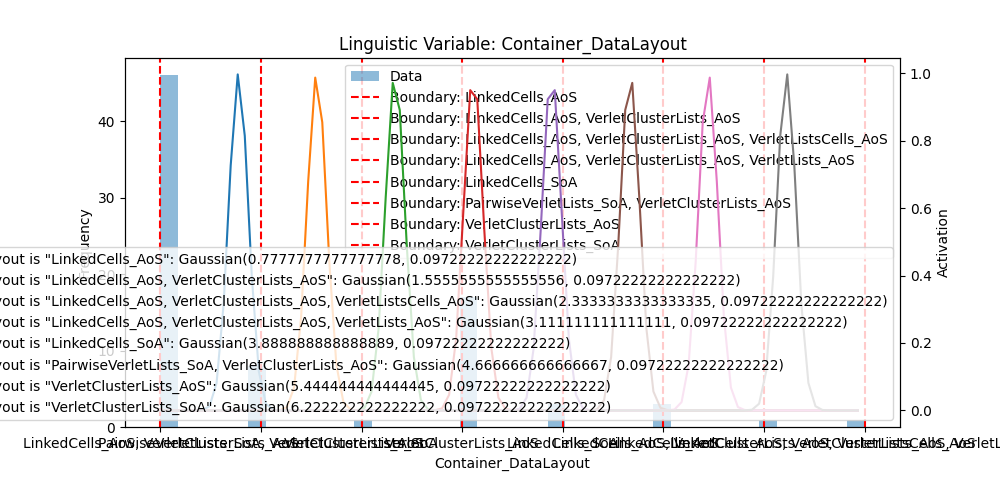

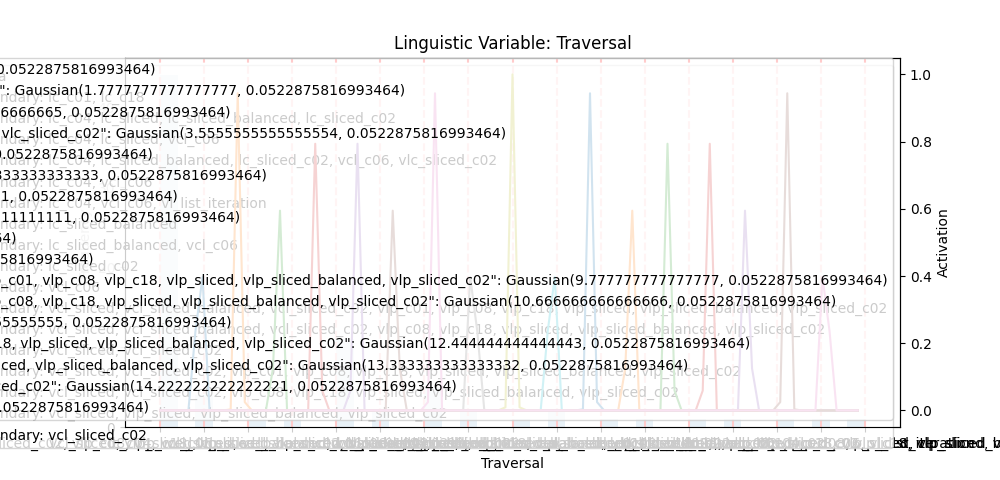

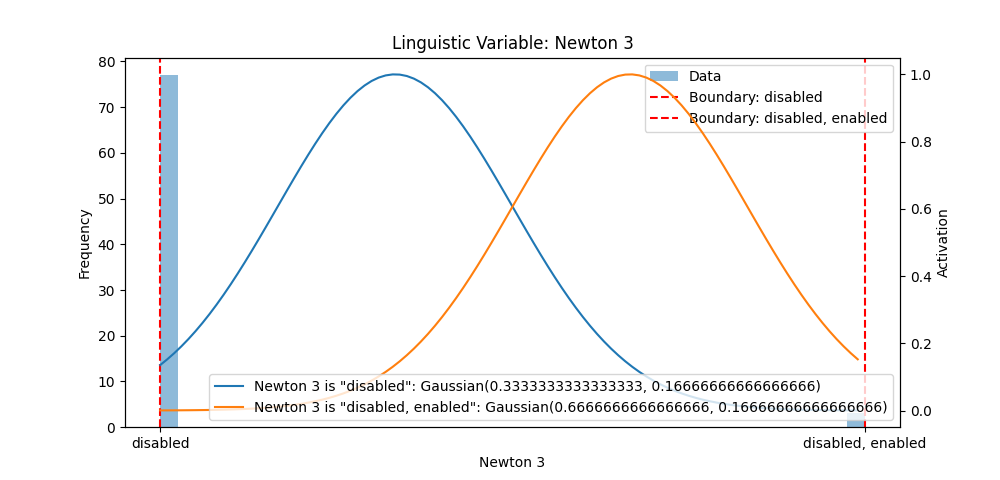

In [18]:
outputRangeMembershipFunctions = create_output_membership_functions(y_train)

# Save all the data


In [20]:
save_linguistic_variables(inputs_approach1, "approach1/fuzzy-inputs.txt")
save_linguistic_variables(outputRangeMembershipFunctions,
                          "approach1/fuzzy-outputs.txt")

save_fuzzy_rules(rules_approach1, "approach1/fuzzy-rules.txt")


save_linguistic_variables(inputs_approach_2, "approach2/fuzzy-inputs.txt")
save_linguistic_variables(outputRangeMembershipFunctions,
                          "approach2/fuzzy-outputs.txt")

save_fuzzy_rules(rules_approach2, "approach2/fuzzy-rules.txt")

FuzzyVariable: domain: "maxDensity" range: (-0.2810033588956048, 2.358903358895605)
	"Very Low": Sigmoid(0.425, -7.136935185923109)
	"Low": Gaussian(0.49050000000000005, 0.06550000000000003)
	"Medium": Gaussian(0.6005, 0.044499999999999984)
	"High": Gaussian(0.758, 0.11299999999999999)
	"Very High": Gaussian(0.9575, 0.08650000000000002)
	"Extremely High": Sigmoid(1.044, 7.136935185923109)

FuzzyVariable: domain: "avgParticlesPerCell" range: (-2.4780250366959757, 9.608103036695976)
	"Extremely Low": Sigmoid(0.221, -36.92307692307691)
	"Very Low": Gaussian(0.3835, 0.16250000000000003)
	"Low": Gaussian(0.646, 0.09999999999999998)
	"Medium": Gaussian(1.083, 0.33699999999999997)
	"High": Gaussian(1.835, 0.41500000000000004)
	"Very High": Gaussian(3.4565, 1.2065000000000001)
	"Extremely High": Sigmoid(4.663, 4.973062577704102)

FuzzyVariable: domain: "maxParticlesPerCell" range: (-4.686058329889828, 61.68605832988983)
	"Very Low": Sigmoid(12.5, -0.2926829268292683)
	"Medium": Gaussian(16.0, 